# How to Develop a Deep CNN for Multi-Label Classification of Photos

Overview

Read the reference URI for details.  Given Planet satellite images that are already trained and classified, create a multi-label response for a given image.  

*Note: You must register for a Kaggle account to get access to the data.*

Again, read the article about getting the data:

https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data

References:
+ https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-satellite-photos-of-the-amazon-rainforest/


In [1]:
# Python 3.7.3
############################################
# INCLUDES
############################################
#libraries specific to this example
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from os import listdir
from numpy import zeros
from numpy import asarray
from numpy import savez_compressed
from pandas import read_csv
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.metrics import fbeta_score
from tensorflow.keras import backend

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# seed the pseudorandom number generator
from random import seed
from random import random
from random import randint

#a set of libraries that perhaps should always be in Python source
import os 
import datetime
import sys
import gc
import getopt
import inspect
import math
import warnings
import types

#Data Science Libraries
import numpy as np
import pandas as pd
import scipy as sp
import scipy.ndimage

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#a darn useful library for creating paths and one I recommend you load to your environment
from pathlib import Path

# can type in the python console `help(name of function)` to get the documentation
from pydoc import help                          

#Import a custom library, in this case a fairly useful logging framework
debug_lib_location = Path("./")
sys.path.append(str(debug_lib_location))
import debug

warnings.filterwarnings('ignore')               # don't print out warnings


root_location="." + os.sep + "data";

In [2]:
#Turn on Eager Execution
#tf.enable_eager_execution()

In [3]:
############################################
#JUPYTER NOTEBOOK OUTPUT CONTROL / FORMATTING
############################################
#set floating point to 4 places to things don't run loose
pd.options.display.float_format = '{:,.4f}'.format
np.set_printoptions(precision=4)

# Variable declaration

In [4]:
############################################
# GLOBAL VARIABLES
############################################
DEBUG = 1                            #General ledger output so you know what's happening.
DEBUG_DATA = 1                       #Extremely verbose output, change to zero (0) to supress the volume of output.

# CODE CONSTRAINTS
VERSION_NAME    = "CNN"
VERSION_ACRONYM = "ML-CNN"
VERSION_MAJOR   = 0
VERSION_MINOR   = 0
VERSION_RELEASE = "7"
VERSION_TITLE   = VERSION_NAME + " (" + VERSION_ACRONYM + ") " + str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE) + " generated SEED."

ENCODING  ="utf-8"
############################################
# GLOBAL CONSTANTS
############################################
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

############################################
# APPLICATION VARIABLES
############################################


############################################
# GLOBAL CONFIGURATION
############################################
os.environ['PYTHONIOENCODING']=ENCODING

## General Function Declaration

In [5]:
############################################
# WARNING / ERROR Management
############################################
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


############################################
# FUNCTIONS
############################################

def prototype(incMonth):

    debug.msg_info("Entering {}.{}".format(__name__, inspect.stack()[0][3]))
    debug.msg_info("The month you passed in was " + str(incMonth))
    debug.msg_info("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))
    return 1

def lib_diagnostics():
    debug.msg_debug("System version    #:{:>12}".format(sys.version))
    netcdf4_version_info = nc.getlibversion().split(" ")
    debug.msg_debug("netCDF4 version   #:{:>12}".format(netcdf4_version_info[0]))
    debug.msg_debug("Matplotlib version#:{:>12}".format(matplt.__version__))
    debug.msg_debug("Numpy version     #:{:>12}".format(np.__version__))
    debug.msg_debug("Pandas version    #:{:>12}".format(pd.__version__))
    debug.msg_debug("SciPy version     #:{:>12}".format(sp.__version__))

    return


def get_full_version():

    resultant = str(VERSION_NAME) + "  v" + str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE)
    return resultant

def get_version():

    resultant = str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE)
    return resultant

def printversion():

    print(get_full_version())

def printusage():

    print("")
    printversion()
    print("  -v, --version    prints the version of this software package.")
    print("")
    print("  * - indicates required argument.")

######################################################################
#Support routines to see columns in DataFrames
######################################################################
def show_columns_plain(inc_ary):
    new_ary = []
    for col in inc_ary:
        new_ary.append(np.char.lower(col))
    new_ary.sort
    myOutputString = " "
    for col in new_ary:
        myOutputString = myOutputString + " " + str(col)
    return myOutputString

def show_columns_true(inc_ary):
    new_ary = []
    for col in inc_ary:
        new_ary.append(col)
    new_ary.sort
    myOutputString = " "
    for col in new_ary:
        myOutputString = myOutputString + " " + str(col)
    return myOutputString

######################################################################
#Input Validation
######################################################################
# valid string:
#  We don't want the following:
#   - at the start of the file name (might be construed as a switch)
#  $, &, |, ;, <, >, `, !, *, ", \ (to start with)
###
def validstring(testsubject):

    if testsubject[0] == "-":
        return 0
    elif "$" in testsubject or "&" in testsubject or "|" in testsubject:
        return 0
    elif ";" in testsubject or "`" in testsubject or "!" in testsubject:
        return 0
    elif "*" in testsubject or '"' in testsubject or "\\" in testsubject:
        return 0
    else:
        return 1
        

In [6]:
# %load ./libs.py
#Title:     Displays the libraries in current use.
#Objective: Invocation is intended as function calls within another program.
#Assumptions:
#           1. Should be stored in standardized location such as:
#                      /p/home/{user_name}/usr/PYTHONLIB
#           2. Developer loads the module (Jupyter Lab).
#Pre-Requisites:
#           1. Python v3.*
#           2. Jupyter Lab / Notebook (%load libs.py)
#Usage:
#       %load libs.py
#       find_loaded_modules().HTML
#
#Version History:
# ------------------------------------------------------------------------
# Version   Date       Modification                              Author
# ------------------------------------------------------------------------
# 1.0       2020/04/29 Inception                                 Radiance
# ------------------------------------------------------------------------
# ------------------------------------------------------------------------


#######################################################################
#LIBRARIES
#######################################################################
import os
import types

def module_version(mod):
    '''Return version string for module *mod*, or nothing if
    it doesn't have a "version" or "__version__" attribute.'''
    version = []
    if hasattr(mod, '__dict__'):
        keys = []
        for key in mod.__dict__.keys():
            if key.lower() == 'version' or key.lower() == '__version__':
                v = mod.__dict__[key]
                if (str):
                    if isinstance(v, str):
                        version.append(v)
                else:
                    version.append("No version")
        if keys:
            print (mod, keys)
    if version:
        return ', '.join(version)
    else:
        return ''

def find_loaded_modules(only_versioned_modules=True):

    def list_of_lists_to_HTML(lists, header_row=None):
        '''Convert a list of a list of strings to a HTML table.'''
        s = '<table>'
        if header_row:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<th>%s</th>' % item for item in header_row])
            s += '\n\t</tr>'
        for inner_list in lists:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<td>%s</td>' % item for item in inner_list])
            s += '\n\t</tr>'
        s += '\n</table>'
        return s
    
    class LoadedModules(list):
        '''Very simple wrapper for a list of lists of strings, with an attribute
        for display in IPython Notebooks.'''
        def __init__(self, *args, **kwargs):
            list.__init__(self, *args, **kwargs)
            
        @property
        def HTML(self):
            from IPython.display import HTML
            return HTML(
                    list_of_lists_to_HTML(
                            self, header_row=['Name', 'Version']))
                    
    objs = LoadedModules()
    for i, mod in enumerate(globals().values()):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__'):
                name = mod.__name__
            else:
                name = ''
            
            version = module_version(mod)
            
            objs.append([mod.__name__, version])
    objs.sort(key=lambda r: r[0])
    return objs


In [7]:
find_loaded_modules().HTML

Name,Version
builtins,
builtins,
datetime,
debug,
gc,
getopt,
inspect,
math,
matplotlib,3.2.1
matplotlib.pyplot,


## Visualize Dataset

After downloading, untarring and looking at the data, let's do a visual inspection.

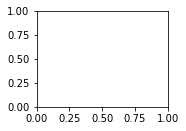

In [8]:
# plot the first 9 images in the planet dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = root_location+os.sep+'train-jpg/'
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    filename = folder + 'train_' + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

## Create Mappings

The next step involves understanding the labels that may be assigned to each image.

Running the example first summarizes the shape of the training dataset. We can see that there are indeed 40,479 training images known to the mapping file.

Next, the first 10 rows of the file are summarized. We can see that the second column of the file contains a space-separated list of tags to assign to each image.

In [9]:
#####################################################################################
# load and summarize the mapping file for the planet dataset
#####################################################################################

#####################################################################################
# Use Pandas to read the csv
#####################################################################################

filename = root_location+os.sep+'train_v2.csv' + os.sep + 'train_v2.csv'
mapping_csv = read_csv(filename)

#####################################################################################
# Summarize the properties
#####################################################################################
debug.msg_debug(str(mapping_csv.shape))
debug.msg_debug((mapping_csv[:10]))

[2021-05-04 13:29:07 Central Daylight Time]   DEBUG: (40479, 2) 
[2021-05-04 13:29:07 Central Daylight Time]   DEBUG:   image_name                                         tags
0    train_0                                 haze primary
1    train_1              agriculture clear primary water
2    train_2                                clear primary
3    train_3                                clear primary
4    train_4    agriculture clear habitation primary road
5    train_5                           haze primary water
6    train_6  agriculture clear cultivation primary water
7    train_7                                 haze primary
8    train_8        agriculture clear cultivation primary
9    train_9   agriculture clear cultivation primary road 


We will need the set of all known tags to be assigned to images, as well as a unique and consistent integer to apply to each tag. This is so that we can develop a target vector for each image with a one hot encoding, e.g. a vector with all zeros and a one at the index for each tag applied to the image.

This can be achieved by looping through each row in the “tags” column, splitting the tags by space, and storing them in a set. We will then have a set of all known tags. For example:

In [10]:
# create a set of labels
labels = set()
for i in range(len(mapping_csv)):
    # convert spaced separated tags into an array of tags
    tags = mapping_csv['tags'][i].split(' ')
    # add tags to the set of known labels
    labels.update(tags)
labels

{'agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water'}

This can then be ordered alphabetically and each tag assigned an integer based on this alphabetic rank.

This will mean that the same tag will always be assigned the same integer for consistency.

In [11]:
# convert set of labels to a list to list
labels = list(labels)
# order set alphabetically
labels.sort()
labels

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

We can create a dictionary that maps tags to integers so that we can encode the training dataset for modeling.

We can also create a dictionary with the reverse mapping from integers to string tag values, so later when the model makes a prediction, we can turn it into something readable.

In [12]:
# dict that maps labels to integers, and the reverse
labels_map = {labels[i]:i for i in range(len(labels))}
inv_labels_map = {i:labels[i] for i in range(len(labels))}

We can tie all of this together into a convenience function called create_tag_mapping() that will take the loaded DataFrame containing the train_v2.csv data and return a mapping and inverse mapping dictionaries.

In [13]:
#####################################################################################
# create a mapping of tags to integers given the loaded mapping file
#####################################################################################
def create_tag_mapping(mapping_csv):
    # create a set of all known tags
    labels = set()
    for i in range(len(mapping_csv)):
        # convert spaced separated tags into an array of tags
        tags = mapping_csv['tags'][i].split(' ')
        # add tags to the set of known labels
        labels.update(tags)
    # convert set of labels to a list to list
    labels = list(labels)
    # order set alphabetically
    labels.sort()
    # dict that maps labels to integers, and the reverse
    labels_map = {labels[i]:i for i in range(len(labels))}
    inv_labels_map = {i:labels[i] for i in range(len(labels))}
    return labels_map, inv_labels_map

We also need a mapping of training set filenames to the tags for the image.

This is a simple dictionary with the filename of the image as the key and the list of tags as the value.

The create_file_mapping() below implements this, also taking the loaded DataFrame as an argument and returning the mapping with the tag value for each filename stored as a list.

In [14]:
#####################################################################################
# create a mapping of filename to tags
#####################################################################################
def create_file_mapping(mapping_csv):
    mapping = dict()
    for i in range(len(mapping_csv)):
        name, tags = mapping_csv['image_name'][i], mapping_csv['tags'][i]
        mapping[name] = tags.split(' ')
    return mapping

In [15]:
#####################################################################################
# create a one hot encoding for one list of tags
#####################################################################################
def one_hot_encode(tags, mapping):
    # create empty vector
    encoding = zeros(len(mapping), dtype='uint8')
    # mark 1 for each tag in the vector
    for tag in tags:
        encoding[mapping[tag]] = 1
    return encoding

## Create In-Memory Dataset

We need to be able to load the JPEG images into memory.

This can be achieved by enumerating all files in the train-jpg/ folder. Keras provides a simple API to load an image from file via the load_img() function and to cover it to a NumPy array via the img_to_array() function.

As part of loading an image, we can force the size to be smaller to save memory and speed up training. In this case, we will halve the size of the image from 256×256 to 128×128. We will also store the pixel values as an unsigned 8-bit integer (e.g. values between 0 and 255).

In [16]:
#####################################################################################
# keras convenience routine to load images
#####################################################################################
def load_dataset(path, file_mapping, tag_mapping):
    photos, targets = list(), list()
    # enumerate files in the directory
    for filename in listdir(folder):
        # load image, resize to more memory conservative approach
        photo = load_img(path + filename, target_size=(128,128))
        # convert to numpy array
        photo = img_to_array(photo, dtype='uint8')
        # get tags
        tags = file_mapping[filename[:-4]]
        # one hot encode tags
        target = one_hot_encode(tags, tag_mapping)
        # store
        photos.append(photo)
        targets.append(target)
    X = asarray(photos, dtype='uint8')
    y = asarray(targets, dtype='uint8')
    return X, y

In [17]:
# save both arrays to one file in compressed format
#savez_compressed('planet_data.npz', X, y)

Now implement the function after re-reading the data.

In [18]:
#####################################################################################
# Use Pandas to read the csv
#####################################################################################
filename = root_location+os.sep+'train_v2.csv' + os.sep + 'train_v2.csv'
mapping_csv = read_csv(filename)

#####################################################################################
# create a mapping of tags to integers
#####################################################################################
tag_mapping, _ = create_tag_mapping(mapping_csv)

#####################################################################################
# create a mapping of filenames to tag lists
#####################################################################################
file_mapping = create_file_mapping(mapping_csv)

#####################################################################################
# load the jpeg images
#####################################################################################
folder = root_location+os.sep+'train-jpg/'
X, y = load_dataset(folder, file_mapping, tag_mapping)
print(X.shape, y.shape)

#####################################################################################
# save both arrays to one file in compressed format
#####################################################################################
savez_compressed('planet_data.npz', X, y)

## Model Evaluation Measure

Before we start modeling, we must select a performance metric.

Classification accuracy is often appropriate for binary classification tasks with a balanced number of examples in each class.

In this case, we are working neither with a binary or multi-class classification task; instead, it is a multi-label classification task and the number of labels are not balanced, with some used more heavily than others.

As such, the Kaggle competition organizes chose the F-beta metric, specifically the F2 score. This is a metric that is related to the F1 score (also called F-measure).

The F1 score calculates the average of the recall and the precision. You may remember that the precision and recall are calculated as follows:

In [19]:
precision = true positives / (true positives + false positives)
recall = true positives / (true positives + false negatives)

SyntaxError: invalid syntax (<ipython-input-19-a392e680a6dd>, line 1)

Precision describes how good a model is at predicting the positive class. Recall describes how good the model is at predicting the positive class when the actual outcome is positive.

The F1 is the mean of these two scores, specifically the harmonic mean instead of the arithmetic mean because the values are proportions. F1 is preferred over accuracy when evaluating the performance of a model on an imbalanced dataset, with a value between 0 and 1 for worst and best possible scores.

The F-beta metric is a generalization of F1 that allows a term called beta to be introduced that weights how important recall is compared to precision when calculating the mean.

A common value of beta is two, and this was the value used in the competition, where recall valued twice as highly as precision. This is often referred to as the F2 score.

The idea of a positive and negative class only makes sense for a binary classification problem. As we are predicting multiple classes, the idea of positive and negative and related terms are calculated for each class in a one vs. rest manner, then averaged across each class.

The scikit-learn library provides an implementation of F-beta via the fbeta_score() function. We can call this function to evaluate a set of predictions and specify a beta value of 2 and the “average” argument set to “samples“.

In [ ]:
F1 = 2 x (precision x recall) / (precision + recall)

F-Beta = (1 + Beta^2) x (precision x recall) / (Beta^2 x precision + recall)

score = fbeta_score(y_true, y_pred, 2, average='samples')

For example, we can test this on our prepared dataset.

We can split our loaded dataset into separate train and test datasets that we can use to train and evaluate models on this problem. This can be achieved using the train_test_split() and specifying a ‘random_state‘ argument so that the same data split is given each time the code is run.

We will use 70% for the training set and 30% for the test set.

In [ ]:
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)

The load_dataset() function below implements this by loading the saved dataset, splitting it into train and test components, and returning them ready for use.

In [ ]:
#####################################################################################
# Load prebuilt/prepped/saved dataset from original Kaggle dataset and split into test/train sets
#####################################################################################
def load_dataset():
    # load dataset
    data = load('planet_data.npz')
    X, y = data['arr_0'], data['arr_1']
    # separate into train and test datasets
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
    print(trainX.shape, trainY.shape, testX.shape, testY.shape)
    return trainX, trainY, testX, testY

We can then make a prediction of all classes or all 1 values in the one hot encoded vectors.

The predictions can then be evaluated using the scikit-learn fbeta_score() function with the true values in the train and test dataset.


In [ ]:
# load dataset
trainX, trainY, testX, testY = load_dataset()

# make all one predictions
train_yhat = asarray([ones(trainY.shape[1]) for _ in range(trainY.shape[0])])
test_yhat = asarray([ones(testY.shape[1]) for _ in range(testY.shape[0])])

# evaluate predictions
train_score = fbeta_score(trainY, train_yhat, 2, average='samples')
test_score = fbeta_score(testY, test_yhat, 2, average='samples')
debug.msg_debug(str('All Ones: train=%.3f, test=%.3f' % (train_score, test_score)))

In [ ]:
#####################################################################################
# calculate fbeta score for multi-class/label classification
#####################################################################################
def fbeta(y_true, y_pred, beta=2):
    # clip predictions
    y_pred = backend.clip(y_pred, 0, 1)
    
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    
    # calculate precision
    p = tp / (tp + fp + backend.epsilon())
    
    # calculate recall
    r = tp / (tp + fn + backend.epsilon())
    
    # calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    return fbeta_score

In [ ]:
# load dataset
trainX, trainY, testX, testY = load_dataset()

# make all one predictions
train_yhat = asarray([ones(trainY.shape[1]) for _ in range(trainY.shape[0])])
test_yhat = asarray([ones(testY.shape[1]) for _ in range(testY.shape[0])])

# evaluate predictions with sklearn
train_score = fbeta_score(trainY, train_yhat, 2, average='samples')
test_score = fbeta_score(testY, test_yhat, 2, average='samples')

debug.msg_debug(str('All Ones (sklearn): train=%.3f, test=%.3f' % (train_score, test_score)))

# evaluate predictions with keras
train_score = fbeta(backend.variable(trainY), backend.variable(train_yhat))
test_score = fbeta(backend.variable(testY), backend.variable(test_yhat))
debug.msg_debug(str('All Ones (keras): train=%.3f, test=%.3f' % (train_score, test_score)))

The output of the final pooling layer will be flattened and fed to a fully connected layer for interpretation then finally to an output layer for prediction.

The model must produce a 17-element vector with a prediction between 0 and 1 for each output class.

## How to Evaluate a Baseline Model

We are now ready to develop and evaluate a baseline convolutional neural network model for the prepared planet dataset.

We will design a baseline model with a VGG-type structure. That is blocks of convolutional layers with small 3×3 filters followed by a max pooling layer, with this pattern repeating with a doubling in the number of filters with each block added.

Specifically, each block will have two convolutional layers with 3×3 filters, ReLU activation and He weight initialization with same padding, ensuring the output feature maps have the same width and height. These will be followed by a max pooling layer with a 3×3 kernel. Three of these blocks will be used with 32, 64 and 128 filters respectively.

The output of the final pooling layer will be flattened and fed to a fully connected layer for interpretation then finally to an output layer for prediction.

The model must produce a 17-element vector with a prediction between 0 and 1 for each output class.

If this were a multi-class classification problem, we would use a softmax activation function and the categorical cross entropy loss function. This would not be appropriate for multi-label classification, as we expect the model to output multiple 1 values, not a single 1 value. In this case, we will use the sigmoid activation function in the output layer and optimize the binary cross entropy loss function.

The model will be optimized with mini-batch stochastic gradient descent with a conservative learning rate of 0.01 and a momentum of 0.9, and the model will keep track of the “fbeta” metric during training.

In [ ]:
# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=17):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(out_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

The pixel values will be normalized before fitting the model. We will achieve this by defining an ImageDataGenerator instance and specify the rescale argument as 1.0/255.0. This will normalize pixel values per batch to 32-bit floating point values, which might be more memory efficient than rescaling all of the pixel values at once in memory.

In [ ]:
# create data generator
datagen = ImageDataGenerator(rescale=1.0/255.0)

We can create iterators from this data generator for both the train and test sets, and in this case, we will use the relatively large batch size of 128 images to accelerate learning.

In [ ]:
# prepare iterators
train_it = datagen.flow(trainX, trainY, batch_size=128)
test_it = datagen.flow(testX, testY, batch_size=128)

The defined model can then be fit using the train iterator, and the test iterator can be used to evaluate the test dataset at the end of each epoch. The model will be fit for 50 epochs.

In [ ]:
# fit model
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)

Once fit, we can calculate the final loss and F-beta scores on the test dataset to estimate the skill of the model.

In [ ]:
# evaluate model
loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))

The fit_generator() function called to fit the model returns a dictionary containing the loss and F-beta scores recorded each epoch on the train and test dataset. We can create a plot of these traces that can provide insight into the learning dynamics of the model.

The summarize_diagnostics() function will create a figure from this recorded history data with one plot showing loss and another the F-beta scores for the model at the end of each training epoch on the train dataset (blue lines) and test dataset (orange lines).

The created figure is saved to a PNG file with the same filename as the script with a “_plot.png” extension. This allows the same test harness to be used with multiple different script files for different model configurations, saving the learning curves in separate files along the way.

In [ ]:
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Fbeta')
	pyplot.plot(history.history['fbeta'], color='blue', label='train')
	pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

We can tie this together and define a function run_test_harness() to drive the test harness, including the loading and preparation of the data as well as definition, fit, and evaluation of the model.

In [ ]:
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow(trainX, trainY, batch_size=128)
	test_it = datagen.flow(testX, testY, batch_size=128)
	# define model
	model = define_model()
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
	# evaluate model
	loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
	# learning curves
	summarize_diagnostics(history)

## How to Improve Model Performance

In the previous section, we defined a baseline model that can be used as the basis for improvement on the planet dataset.

The model achieved a reasonable F-beta score, although the learning curves suggested that the model had overfit the training dataset. Two common approaches to explore to address overfitting are dropout regularization and data augmentation. Both have the effect of disrupting and slowing down the learning process, specifically the rate that the model improves over training epochs.

We will explore both of these methods in this section. Given that we expect the rate of learning to be slowed, we give the model more time to learn by increasing the number of training epochs from 50 to 200.

##Dropout Regularization

Dropout regularization is a computationally cheap way to regularize a deep neural network.

Dropout works by probabilistically removing, or “dropping out,” inputs to a layer, which may be input variables in the data sample or activations from a previous layer. It has the effect of simulating a large number of networks with very different network structure and, in turn, making nodes in the network generally more robust to the inputs.

For more information on dropout, see the post:

    How to Reduce Overfitting With Dropout Regularization in Keras

Typically, a small amount of dropout can be applied after each VGG block, with more dropout applied to the fully connected layers near the output layer of the model.

Below is the define_model() function for an updated version of the baseline model with the addition of Dropout. In this case, a dropout of 20% is applied after each VGG block, with a larger dropout rate of 50% applied after the fully connected layer in the classifier part of the model.

In [ ]:
#full example with drop-out defined
# baseline model with dropout on the planet dataset
import sys
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD

# load train and test dataset
def load_dataset():
	# load dataset
	data = load('planet_data.npz')
	X, y = data['arr_0'], data['arr_1']
	# separate into train and test datasets
	trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
	print(trainX.shape, trainY.shape, testX.shape, testY.shape)
	return trainX, trainY, testX, testY

# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score

# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=17):
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(out_shape, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Fbeta')
	pyplot.plot(history.history['fbeta'], color='blue', label='train')
	pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow(trainX, trainY, batch_size=128)
	test_it = datagen.flow(testX, testY, batch_size=128)
	# define model
	model = define_model()
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=200, verbose=0)
	# evaluate model
	loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

## Image Data Augmentation

Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.

Training deep learning neural network models on more data can result in more skillful models, and the augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images.

Data augmentation can also act as a regularization technique, adding noise to the training data and encouraging the model to learn the same features, invariant to their position in the input.

Small changes to the input photos of the satellite photos might be useful for this problem, such as horizontal flips, vertical flips, rotations, zooms, and perhaps more. These augmentations can be specified as arguments to the ImageDataGenerator instance, used for the training dataset. The augmentations should not be used for the test dataset, as we wish to evaluate the performance of the model on the unmodified photographs.

This requires that we have a separate ImageDataGenerator instance for the train and test dataset, then iterators for the train and test sets created from the respective data generators. For example:

In [ ]:
# create data generator
train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, vertical_flip=True, rotation_range=90)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare iterators
train_it = train_datagen.flow(trainX, trainY, batch_size=128)
test_it = test_datagen.flow(testX, testY, batch_size=128)

In this case, photos in the training dataset will be augmented with random horizontal and vertical flips as well as random rotations of up to 90 degrees. Photos in both the train and test steps will have their pixel values scaled in the same way as we did for the baseline model.

The full code listing of the baseline model with training data augmentation for the planet dataset is listed below for completeness.

In [ ]:
#complete example with image generators included
# baseline model with data augmentation for the planet dataset
import sys
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

# load train and test dataset
def load_dataset():
	# load dataset
	data = load('planet_data.npz')
	X, y = data['arr_0'], data['arr_1']
	# separate into train and test datasets
	trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
	print(trainX.shape, trainY.shape, testX.shape, testY.shape)
	return trainX, trainY, testX, testY

# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score

# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=17):
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(out_shape, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Fbeta')
	pyplot.plot(history.history['fbeta'], color='blue', label='train')
	pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# create data generator
	train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, vertical_flip=True, rotation_range=90)
	test_datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = train_datagen.flow(trainX, trainY, batch_size=128)
	test_it = test_datagen.flow(testX, testY, batch_size=128)
	# define model
	model = define_model()
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=200, verbose=0)
	# evaluate model
	loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

## Discussion

We have explored two different improvements to the baseline model.

The results can be summarized below, although we must assume some variance in these results given the stochastic nature of the algorithm:

    Baseline + Dropout Regularization: 0.859
    Baseline + Data Augmentation: 0.882

As suspected, the addition of regularization techniques slows the progression of the learning algorithms and reduces overfitting, resulting in improved performance on the holdout dataset. It is likely that the combination of both approaches with a further increase in the number of training epochs will result in further improvements. That is, the combination of both dropout with data augmentation.

This is just the beginning of the types of improvements that can be explored on this dataset. In addition to tweaks to the regularization methods described, other regularization methods could be explored such as weight decay and early stopping.

It may be worth exploring changes to the learning algorithm, such as changes to the learning rate, use of a learning rate schedule, or an adaptive learning rate such as Adam.

Alternate model architectures may also be worth exploring. The chosen baseline model is expected to offer more capacity than may be required for this problem and a smaller model may faster to train and in turn could result in better performance.

## How to Use Transfer Learning

Transfer learning involves using all or parts of a model trained on a related task.

Keras provides a range of pre-trained models that can be loaded and used wholly or partially via the Keras Applications API.

A useful model for transfer learning is one of the VGG models, such as VGG-16 with 16 layers that, at the time it was developed, achieved top results on the ImageNet photo classification challenge.

The model is comprised of two main parts: the feature extractor part of the model that is made up of VGG blocks, and the classifier part of the model that is made up of fully connected layers and the output layer.

We can use the feature extraction part of the model and add a new classifier part of the model that is tailored to the planets dataset. Specifically, we can hold the weights of all of the convolutional layers fixed during training and only train new fully connected layers that will learn to interpret the features extracted from the model and make a suite of binary classifications.

This can be achieved by loading the VGG-16 model, removing the fully connected layers from the output-end of the model, then adding the new fully connected layers to interpret the model output and make a prediction. The classifier part of the model can be removed automatically by setting the “include_top” argument to “False“, which also requires that the shape of the input be specified for the model, in this case (128, 128, 3). This means that the loaded model ends at the last max pooling layer, after which we can manually add a Flatten layer and the new classifier fully-connected layers.

See: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-satellite-photos-of-the-amazon-rainforest/, section on Transfer Learning

Also note that Keras has a number of pre-trained models to work with:

https://keras.io/api/applications/